### After crating the KDEs, it is believed that our model is generalizable across our 3 tested species. Here we will try to make the CVM generalized as well as tune more based off the previous model found in svm_cell_data. We hope that since our training will also now have more positive hits, that this model, although genealized, will be more accurate

In [40]:
import numpy as np
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

#### Download the data

In [2]:
ath_data = pd.read_csv("raw_data/ath.csv")
cel_data = pd.read_csv("raw_data/cel.csv")
dme_data = pd.read_csv("raw_data/dme.csv")
dme_data.columns = dme_data.columns.str.strip()  # for some reason the schema in DME have a leading white space

/var/folders/cs/48rd607d56dgkby39r27lkdr0000gn/T/ipykernel_18366/2455590579.py:3: DtypeWarning: Columns (22,75) have mixed types. Specify dtype option on import or set low_memory=False.
  dme_data = pd.read_csv("raw_data/dme.csv")


In [42]:
cel_data = cel_data.dropna()
dme_data = dme_data.dropna()
ath_data = ath_data.dropna()

combined_data = pd.concat([cel_data, dme_data, ath_data])

In [43]:
x_data = combined_data[['mfe', 'efe', 'dG', 'triplets0', 'mfei4', 'dP', 'bp_number']]
y_data = combined_data[['CLASS']]

In [44]:
all_test_np = y_data.values
all_data_np = x_data.values

In [45]:
from sklearn.model_selection import train_test_split
import torch

### split data

In [46]:
# Splitting data into 80% train and 20% test
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=13)

# Further splitting the remaining 80% into 75% train and 25% validation
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=13)

In [47]:
train_x = torch.tensor(train_x.values, dtype=torch.float32)
train_y = torch.tensor(train_y.values, dtype=torch.float32)
val_x = torch.tensor(val_x.values, dtype=torch.float32)
val_y = torch.tensor(val_y.values, dtype=torch.float32)
test_x = torch.tensor(test_x.values, dtype=torch.float32)
test_y = torch.tensor(test_y.values, dtype=torch.float32)

In [31]:
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

### SVM Class

In [69]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.utils import resample

class NonLinearSVM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_rate=0.2):
        super(NonLinearSVM, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer3 = nn.Linear(hidden_size2, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.layer2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out = self.layer3(out)
        
        return out

### Used for balancing issues

In [49]:
pos_indices = np.where(train_y.numpy() == 1)[0]
neg_indices = np.where(train_y.numpy() == 0)[0]

# Subsample negative indices to match the size of positive indices
neg_subset_indices = resample(neg_indices, replace=False, n_samples=len(pos_indices), random_state=13)

balanced_indices = np.concatenate([pos_indices, neg_subset_indices])

# Create balanced dataset
X_balanced = train_x[balanced_indices]
y_balanced = train_y[balanced_indices]

train_dataset = torch.utils.data.TensorDataset(X_balanced, y_balanced)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

### hyper paramaters

In [119]:
input_size = X_balanced.shape[1]
hidden_size1 = 64
hidden_size2 = 128
learning_rate = 0.001
num_epochs = 40
dropout_rate = 0.2

### model

Epoch 1 - Loss: 0.7396215862698026, Validation Loss: 0.8486134993900625
Epoch 2 - Loss: 0.6877903375360701, Validation Loss: 0.8328851984120155
Epoch 3 - Loss: 0.6696253518263499, Validation Loss: 0.8178033484525459
Epoch 4 - Loss: 0.6463905904028151, Validation Loss: 0.8048175910018212
Epoch 5 - Loss: 0.6178664664427439, Validation Loss: 0.7948971831743107
Epoch 6 - Loss: 0.6115522020392947, Validation Loss: 0.7838425700683003
Epoch 7 - Loss: 0.6114994883537292, Validation Loss: 0.7691057832814002
Epoch 8 - Loss: 0.5983058644665612, Validation Loss: 0.7544827062880346
Epoch 9 - Loss: 0.5902324716250101, Validation Loss: 0.7439600886078768
Epoch 10 - Loss: 0.5777448481983609, Validation Loss: 0.7326142807598262
Epoch 11 - Loss: 0.5639035503069559, Validation Loss: 0.7276278691143953
Epoch 12 - Loss: 0.5590632789664798, Validation Loss: 0.7184248703062073
Epoch 13 - Loss: 0.5475589765442742, Validation Loss: 0.7042701801625333
Epoch 14 - Loss: 0.5469393465254042, Validation Loss: 0.6915

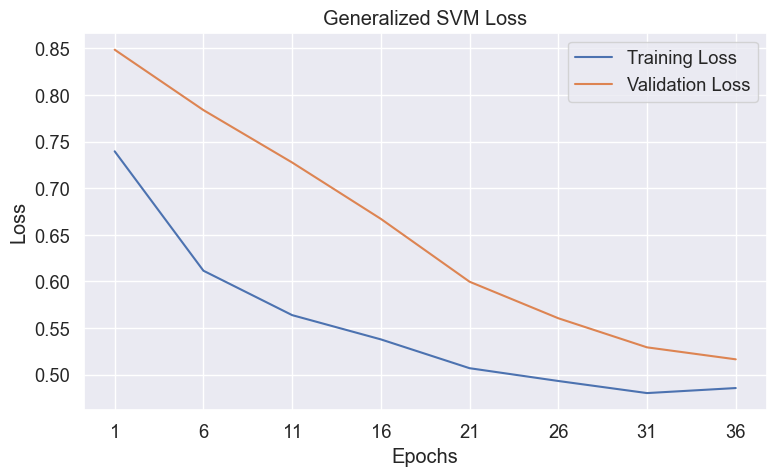

In [120]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Initialize lists to store training and validation loss
train_losses = []
val_losses = []

model = NonLinearSVM(input_size, hidden_size1, hidden_size2, dropout_rate)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))  # Store training loss

    # Evaluation on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            labels = labels.float()
            val_loss += criterion(outputs, labels).item()
    val_losses.append(val_loss / len(val_loader))  # Store validation loss

    # Print epoch statistics
    print(f"Epoch {epoch+1} - Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

# Plotting epochs
epochs = range(1, num_epochs + 1)  # Create a list of epochs from 1 to num_epochs
plot_epochs = epochs[::5]  # Select every 5th epoch for plotting
plt.figure(figsize=(8, 5))

# Plotting Loss
plt.plot(plot_epochs, [train_losses[i] for i in range(0, len(train_losses), 5)], label='Training Loss')
plt.plot(plot_epochs, [val_losses[i] for i in range(0, len(val_losses), 5)], label='Validation Loss')
plt.xticks(plot_epochs)
plt.title('Generalized SVM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



### confusion matrix

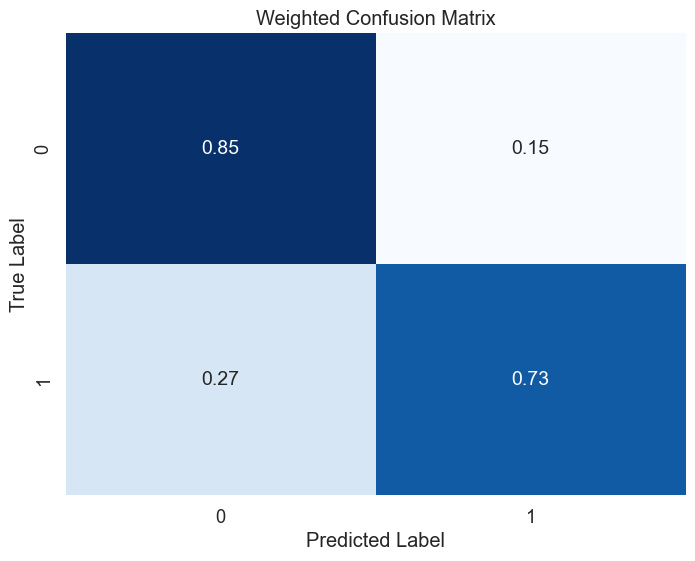

In [83]:
from sklearn.metrics import confusion_matrix

# Evaluate on validation set
model.eval()
predictions = []
true_labels = []

for data in val_loader:
    inputs, labels = data
    outputs = model(inputs)
    predicted = (outputs > 0).squeeze().int()
    predictions.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

conf_matrix = confusion_matrix(true_labels, predictions)

sum_true_labels = conf_matrix.sum(axis=1)

# Normalize each row of the confusion matrix by the sum of true labels
weighted_conf_matrix = conf_matrix / sum_true_labels[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(weighted_conf_matrix, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 14}, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Weighted Confusion Matrix')
plt.show()

# Test!

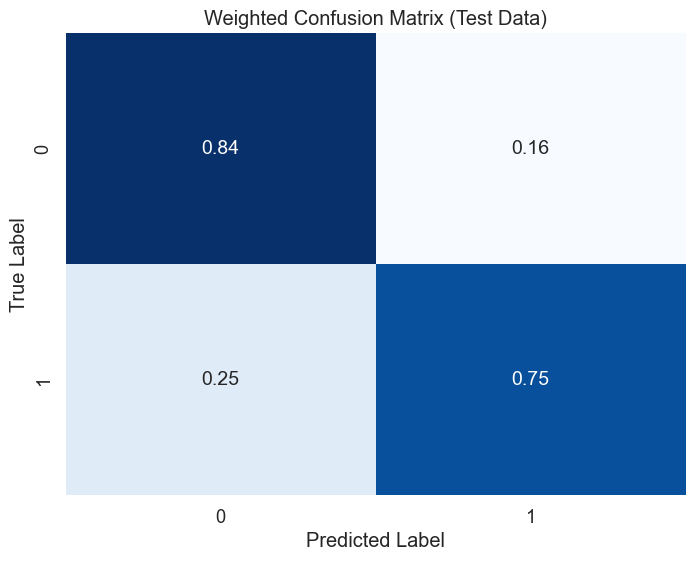

Total Accuracy on Test Data: 0.836340221170506


In [124]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

test_predictions = []
test_true_labels = []

for data in test_loader:
    inputs, labels = data
    outputs = model(inputs)
    predicted = (outputs > 0).squeeze().int()
    test_predictions.extend(predicted.tolist())
    test_true_labels.extend(labels.tolist())

# Convert predictions and true labels to numpy arrays
test_predictions = np.array(test_predictions)
test_true_labels = np.array(test_true_labels)

test_conf_matrix = confusion_matrix(test_true_labels, test_predictions)
sum_true_labels_test = test_conf_matrix.sum(axis=1)
weighted_conf_matrix_test = test_conf_matrix / sum_true_labels_test[:, np.newaxis]

# Plot weighted confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(weighted_conf_matrix_test, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 14}, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Weighted Confusion Matrix (Test Data)')
plt.show()

# Compute total accuracy
test_accuracy = accuracy_score(test_true_labels, test_predictions)
print("Total Accuracy on Test Data:", test_accuracy)
